# Exploratory Data Analysis


## 1. Setup


### 1.1 Imports


In [1]:
from scripts.data_loader import load_data, split_features_targets
from scripts.preprocessing import preprocess_data
from scripts.plotting import (
    save_plots,
    plot_group_histogram,
    plot_group_boxplot,
    plot_group_line_chart,
    plot_group_spatial_heatmap,
    plot_spatial_heatmap,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 1.2 Loading Dataset


In [3]:
# Load data into DataFrames.
df = load_data("data")
df = preprocess_data(df)
print(f"📊 Data: \n {df.head()}\n")
features, targets = split_features_targets(df)
variables = [
    "air_temperature",
    "ocean_temperature",
    "precipitation",
    "ice_thickness",
    "ice_mask",
    "ice_velocity",
]
boundary_conditions = ["precipitation", "air_temperature", "ocean_temperature"]

📊 Data: 
      x   y  ice_thickness  ice_velocity  ice_mask  precipitation  \
14 -11  25            0.0           0.0         4      -0.024865   
15 -10  25            0.0           0.0         4      -0.056667   
16  -9  25            0.0           0.0         4      -0.071863   
17  -8  25            0.0           0.0         4      -0.084515   
18  -7  25            0.0           0.0         4      -0.091750   

    air_temperature  ocean_temperature  year  
14         0.836595          -0.034495  2015  
15         0.830760          -0.079245  2015  
16         0.825038          -0.114335  2015  
17         0.819387          -0.139854  2015  
18         0.814295          -0.157410  2015  



,x,y,ice_thickness,ice_velocity,ice_mask,precipitation,air_temperature,ocean_temperature,year
count,194102.0000,194102.0000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000,194102.000000
mean,0.0000,0.0000,0.169607,5.751969,3.185825,-0.058856,0.658011,0.166677,2057.500000
std,13.4209,13.4209,0.252686,31.811456,0.970682,0.535562,0.266348,0.789064,24.824447
min,-25.0000,-25.0000,0.000000,0.000000,2.000000,-0.842799,0.000000,-1.228246,2015.000000
25%,-11.0000,-11.0000,0.000000,0.000000,2.000000,-0.618690,0.453780,-0.419754,2036.000000
50%,0.0000,0.0000,0.000000,0.000000,4.000000,0.000000,0.785839,0.000000,2057.500000
75%,11.0000,11.0000,0.359591,1.000000,4.000000,0.381310,0.862117,0.580246,2079.000000
max,25.0000,25.0000,1.000000,2060.210839,4.000000,2.837715,1.000000,3.679689,2100.000000


## 2. Feature Space


In [ ]:
for feature in variables:
    save_plots(df, f"out/images/{feature}", feature)

### 2.0 Data Descriptions


In [ ]:
# Describe the data.
print(f"📊 Data description: \n {df.describe()}\n")

### 2.1 NaN Values


In [ ]:
# Plot NaN values in each column
NaN_values = df.isna().sum()
sns.barplot(x=NaN_values.index, y=NaN_values.values)
plt.xticks(rotation=90)
plt.title("NaN values per column")
plt.xlabel("Columns")
plt.ylabel("NaN values")
plt.show()

print(f"📊 NaN values per column: \n {df.isna().sum()}\n")

# calculate each columns proportion of NaN values
NaN_proportion = df.isna().sum() / len(df)
print(f"📊 NaN values proportion per column: \n {NaN_proportion}\n")

# Plot a heatmap of NaN values
plot_spatial_heatmap(df, "ocean_temperature")

### 2.2 Outliers


In [ ]:
plot_group_boxplot(df, variables, 2, 3)

### 2.3 Duplicates


In [ ]:
print(f"📊 Duplicates: {df.duplicated().sum()}")

### 2.4 Univariate Analysis


In [ ]:
plot_group_histogram(df, variables, 2, 3)

### 2.5 Static Spatial Representations


In [ ]:
plot_group_spatial_heatmap(df, variables, 2, 3)

### 2.6 Dynamic Spatial Representations


In [ ]:
for feature in variables:
    #create_heatmap_gif(df, feature)

### 2.7 Temporal Representations


In [ ]:
plot_group_line_chart(df, variables, 2, 3)

## 3. Correlation Analysis


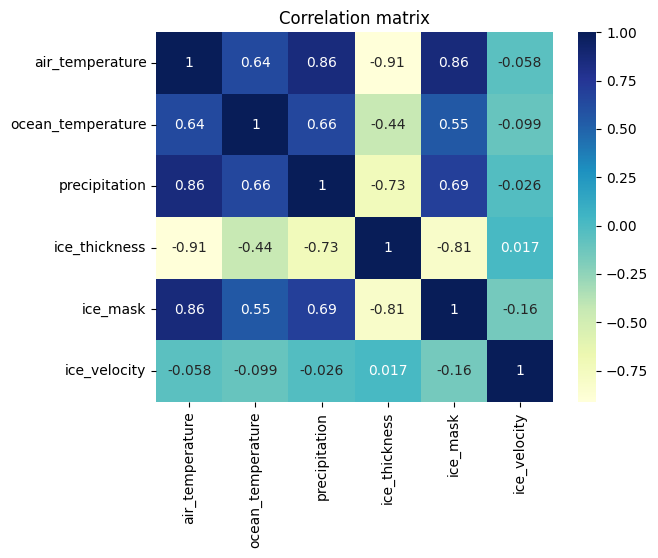

In [4]:
# Plot a correlation matrix
corr = df[variables].corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix")
plt.show()

## 4. Feature Engineering


### 3.2 Feature Creation


In [3]:
created_features = []

# Distance to Pole
df["dtp"] = np.sqrt((df["x"] - 4) ** 2 + df["y"] ** 2)
created_features.append("dtp")

# Rolling Standard Deviation
for feature in ["precipitation", "air_temperature"]:
    df[f"{feature}_rolling_std"] = df[feature].rolling(window=3).std()
    created_features.extend([f"{feature}_rolling_std"])

# Log Transformation of air_temperature
df["log_air_temperature"] = np.log(df["air_temperature"] + 1)
created_features.append("log_air_temperature")

# Coastline Encoding
df["coastline"] = 0
for index, row in df.iterrows():
    if row["ice_mask"] == 2:
        x = row["x"]
        y = row["y"]
        if (
            ((df["x"] == x) & (df["y"] == y + 1) & (df["ice_mask"] == 4)).any()
            or ((df["x"] == x) & (df["y"] == y - 1) & (df["ice_mask"] == 4)).any()
            or ((df["x"] == x + 1) & (df["y"] == y) & (df["ice_mask"] == 4)).any()
            or ((df["x"] == x - 1) & (df["y"] == y) & (df["ice_mask"] == 4)).any()
        ):
            df.at[index, "coastline"] = 1
created_features.append("coastline")

### 3.3 Created Feature Analysis


          dtp  precipitation_rolling_std  air_temperature_rolling_std  \
14  29.154759                        NaN                          NaN   
15  28.653098                        NaN                          NaN   
16  28.178006                   0.023983                     0.005778   
17  27.730849                   0.013944                     0.005687   
18  27.313001                   0.010065                     0.005374   

    log_air_temperature  coastline  
14             0.607913          0  
15             0.604731          0  
16             0.601601          0  
17             0.598499          0  
18             0.595697          0  


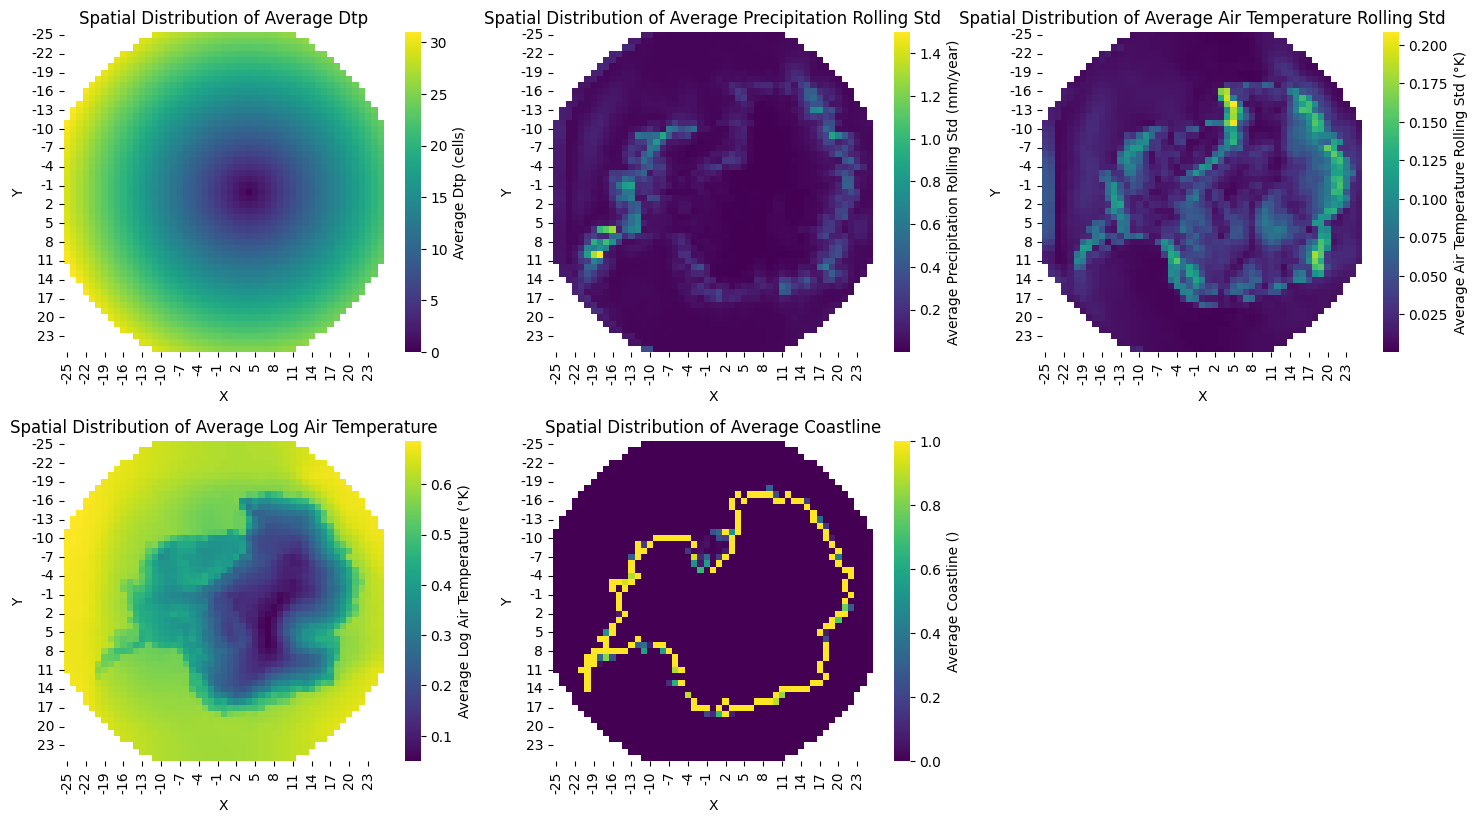

In [4]:
df_created = df[created_features]
print(df_created.head())
plot_group_spatial_heatmap(df, created_features, 4, 3)

### 3.4 Created Feature Correlation Analysis


In [ ]:
created_with_targets = created_features + targets.columns.tolist()
corr = df[created_with_targets].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix of Created Features with Targets")
plt.show()